# Variational Autoencoder
Build a variational autoencoder to work on fashion-MNIST data set. "Hands-On Machine Learning", by Aurelien Geron, is the basis for much of the code. https://github.com/ageron/handson-ml2

In [1]:
import numpy as np
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorboard

print('TensorFlow version: ', tf.__version__)
print('Keras version: ', keras.__version__)
print('Tensorboard version:', tensorboard.__version__)

%matplotlib inline

TensorFlow version:  2.0.0
Keras version:  2.2.4-tf
Tensorboard version: 2.0.0


## 1.0 Load and Prepare Data

In [4]:
# load fashion MNIST
fashion_mnist = keras.datasets.fashion_mnist
(X_train_all, y_train_all), (X_test, y_test) = fashion_mnist.load_data()

In [5]:
# check the shape of the data sets
print('X_train_full shape:', X_train_all.shape)
print('y_train_full shape:', y_train_all.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train_full shape: (60000, 28, 28)
y_train_full shape: (60000,)
X_test shape: (10000, 28, 28)
y_test shape: (10000,)


In [6]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [7]:
# split the data between train and validation sets, and scale

X_valid, X_train = X_train_all[:5000] / 255.0, X_train_all[5000:] / 255.0
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

# also scale the X_test
X_test = X_test / 255.0

print('X_valid shape:', X_valid.shape)
print('y_valid shape:', y_valid.shape)
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

X_valid shape: (5000, 28, 28)
y_valid shape: (5000,)
X_train shape: (55000, 28, 28)
y_train shape: (55000,)


## 2.0 Variational Autoencoder
Build the variational autoencoder. First, we will create a custom function to sample the mean and log-variables.

In [128]:
# build custom sampling function
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [129]:
# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [130]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

variational_encoder.summary()
variational_decoder.summary()

Model: "model_33"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_12 (Flatten)            (None, 784)          0           input_24[0][0]                   
__________________________________________________________________________________________________
dense_81 (Dense)                (None, 150)          117750      flatten_12[0][0]                 
__________________________________________________________________________________________________
dense_82 (Dense)                (None, 100)          15100       dense_81[0][0]                   
___________________________________________________________________________________________

In [131]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Train on 55000 samples, validate on 5000 samples
Epoch 1/25
55000/55000 [==============================] - 3s 59us/sample - loss: 0.3906 - rounded_accuracy: 0.8601 - val_loss: 0.3469 - val_rounded_accuracy: 0.8886
Epoch 2/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3426 - rounded_accuracy: 0.8980 - val_loss: 0.3382 - val_rounded_accuracy: 0.8932
Epoch 3/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3330 - rounded_accuracy: 0.9050 - val_loss: 0.3313 - val_rounded_accuracy: 0.9011
Epoch 4/25
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3279 - rounded_accuracy: 0.9091 - val_loss: 0.3236 - val_rounded_accuracy: 0.9089
Epoch 5/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3248 - rounded_accuracy: 0.9118 - val_loss: 0.3219 - val_rounded_accuracy: 0.9155
Epoch 6/25
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3226 - rounded_accuracy: 0.9137 - val_loss:

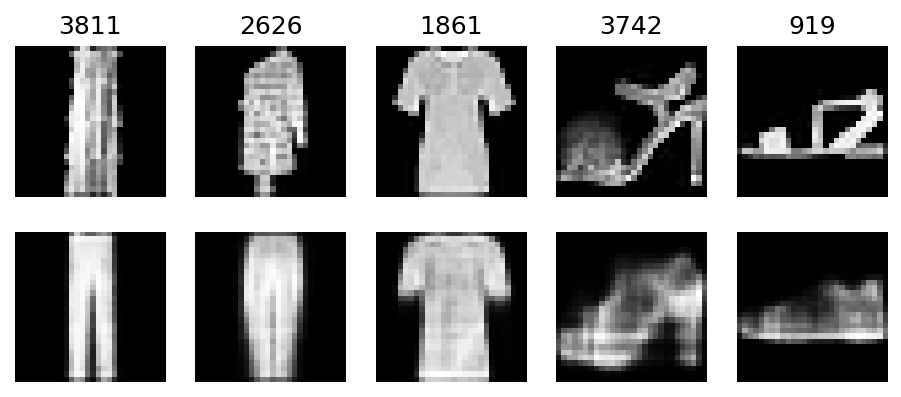

In [132]:
# plot the results
def plot_reconstructions(model, index_list, X_valid): 
    reconstructions = model.predict(X_valid)
    
    # get the length of index_list to set number of
    # images to plot
    n_images = len(index_list)

    # Plot a random sample
    fig, axes = plt.subplots(2, n_images,figsize=(n_images*1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    for i in range(0, n_images):
        axes[0][i].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[0][i].axis('off')
        axes[0][i].set_title(str(index_list[i]))
        axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
        axes[1][i].axis('off')
        
    plt.show()

import random
index_list = random.sample(range(0,len(X_valid)), 5)
plot_reconstructions(variational_ae, index_list, X_valid)

In [150]:
X_valid_vae_encoded = variational_encoder.predict(X_valid, batch_size=128)

In [151]:
np.shape(X_valid_vae_encoded)

(3, 5000, 10)

## 3.0 Disentangled Variational Autoencoder

In [135]:
# build custom sampling function
K = keras.backend

class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean
    
# rounded accuracy for the metric
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [180]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10
beta_value = 0.3

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder_beta = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder_beta = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder_beta(inputs)
reconstructions = variational_decoder_beta(codings)
variational_ae_beta = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * beta_value * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae_beta.add_loss(K.mean(latent_loss) / 784.)
variational_ae_beta.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])

variational_encoder_beta.summary()
variational_decoder_beta.summary()


# make tensorboard callback and name folder
log_dir="logs/" + str('vae_') + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0,
                                                      update_freq='epoch',profile_batch=0)

Model: "model_51"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_36 (InputLayer)           [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
flatten_18 (Flatten)            (None, 784)          0           input_36[0][0]                   
__________________________________________________________________________________________________
dense_123 (Dense)               (None, 150)          117750      flatten_18[0][0]                 
__________________________________________________________________________________________________
dense_124 (Dense)               (None, 100)          15100       dense_123[0][0]                  
___________________________________________________________________________________________

In [181]:
history = variational_ae_beta.fit(X_train, X_train, epochs=10, batch_size=128,
                             validation_data=[X_valid, X_valid],callbacks=[tensorboard_callback])

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 3s 63us/sample - loss: 0.3660 - rounded_accuracy: 0.8726 - val_loss: 0.3262 - val_rounded_accuracy: 0.9029
Epoch 2/10
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3256 - rounded_accuracy: 0.9052 - val_loss: 0.3182 - val_rounded_accuracy: 0.9073
Epoch 3/10
55000/55000 [==============================] - 2s 40us/sample - loss: 0.3164 - rounded_accuracy: 0.9119 - val_loss: 0.3121 - val_rounded_accuracy: 0.9166
Epoch 4/10
55000/55000 [==============================] - 2s 37us/sample - loss: 0.3116 - rounded_accuracy: 0.9157 - val_loss: 0.3053 - val_rounded_accuracy: 0.9206
Epoch 5/10
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3085 - rounded_accuracy: 0.9181 - val_loss: 0.3069 - val_rounded_accuracy: 0.9182
Epoch 6/10
55000/55000 [==============================] - 2s 38us/sample - loss: 0.3064 - rounded_accuracy: 0.9197 - val_loss:

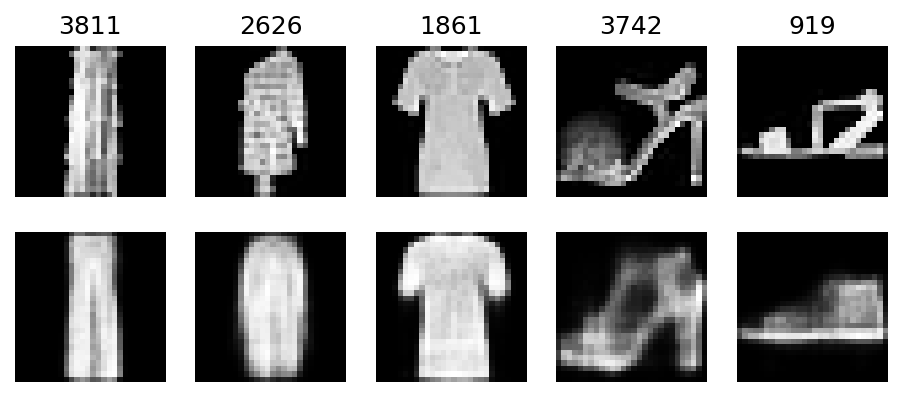

In [182]:
plot_reconstructions(variational_ae_beta, index_list, X_valid)

Let's try and cluster some of the results...

In [183]:
# check out variational encoder
variational_encoder_beta

In [184]:
X_valid_encoded = variational_encoder_beta.predict(X_valid, batch_size=128)

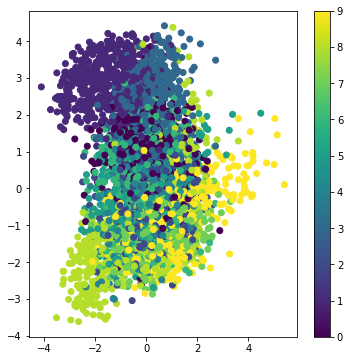

In [185]:
plt.figure(figsize=(6,6))
plt.scatter(X_valid_encoded[2][:,0], X_valid_encoded[2][:,1], c=y_valid)
plt.colorbar()
plt.show()

In [ ]:
X_valid_encoded[2][:,0]

In [175]:
# try to use T-SNE
# code from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

np.random.seed(63)

from sklearn.manifold import TSNE

tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_encoded[2][:,:])
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

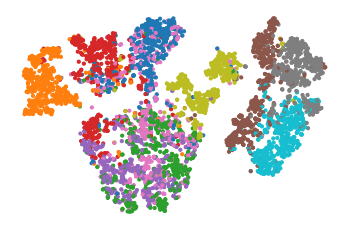

In [176]:
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Try and recreate some image like in the Beta-VAE original paper...

In [192]:
X_bvae_encoder = np.array(X_valid_encoded[2])

In [193]:
np.shape(X_bvae_encoder)

(5000, 10)

In [198]:
# plots from https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid)[2].numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])


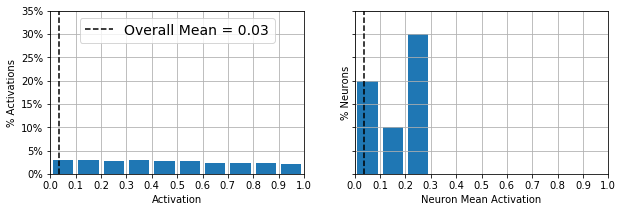

In [207]:
plot_activations_histogram(variational_encoder_beta, height=0.35)
plt.show()

In [205]:
X_valid_codings = variational_encoder_beta(X_valid)[2].numpy()

In [206]:
np.shape(X_valid_codings)

(5000, 10)

In [208]:
decoder_inputs

<tf.Tensor 'input_37:0' shape=(None, 10) dtype=float32>

In [209]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[1, codings_size])

In [210]:
codings

<tf.Tensor: id=1632553, shape=(1, 10), dtype=float32, numpy=
array([[ 0.3274685 , -0.8426258 ,  0.3194337 , -1.4075519 , -2.3880599 ,
        -1.0392479 , -0.5573232 ,  0.539707  ,  1.6994323 ,  0.28893656]],
      dtype=float32)>

In [223]:
codings_zero = np.zeros((1,10), dtype='float32')
print(codings_zero)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


(-0.5, 27.5, 27.5, -0.5)

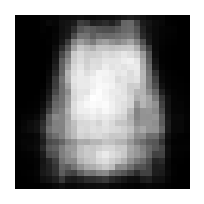

In [224]:
tf.random.set_seed(15)

# codings = tf.random.normal(shape=[1, codings_size])

img = variational_decoder_beta(codings_zero)

fig, axes = plt.subplots(1, 1,figsize=(1.5,3),dpi=150)
axes.imshow(np.reshape(img,[28,28]), cmap='Greys_r')
axes.axis('off')

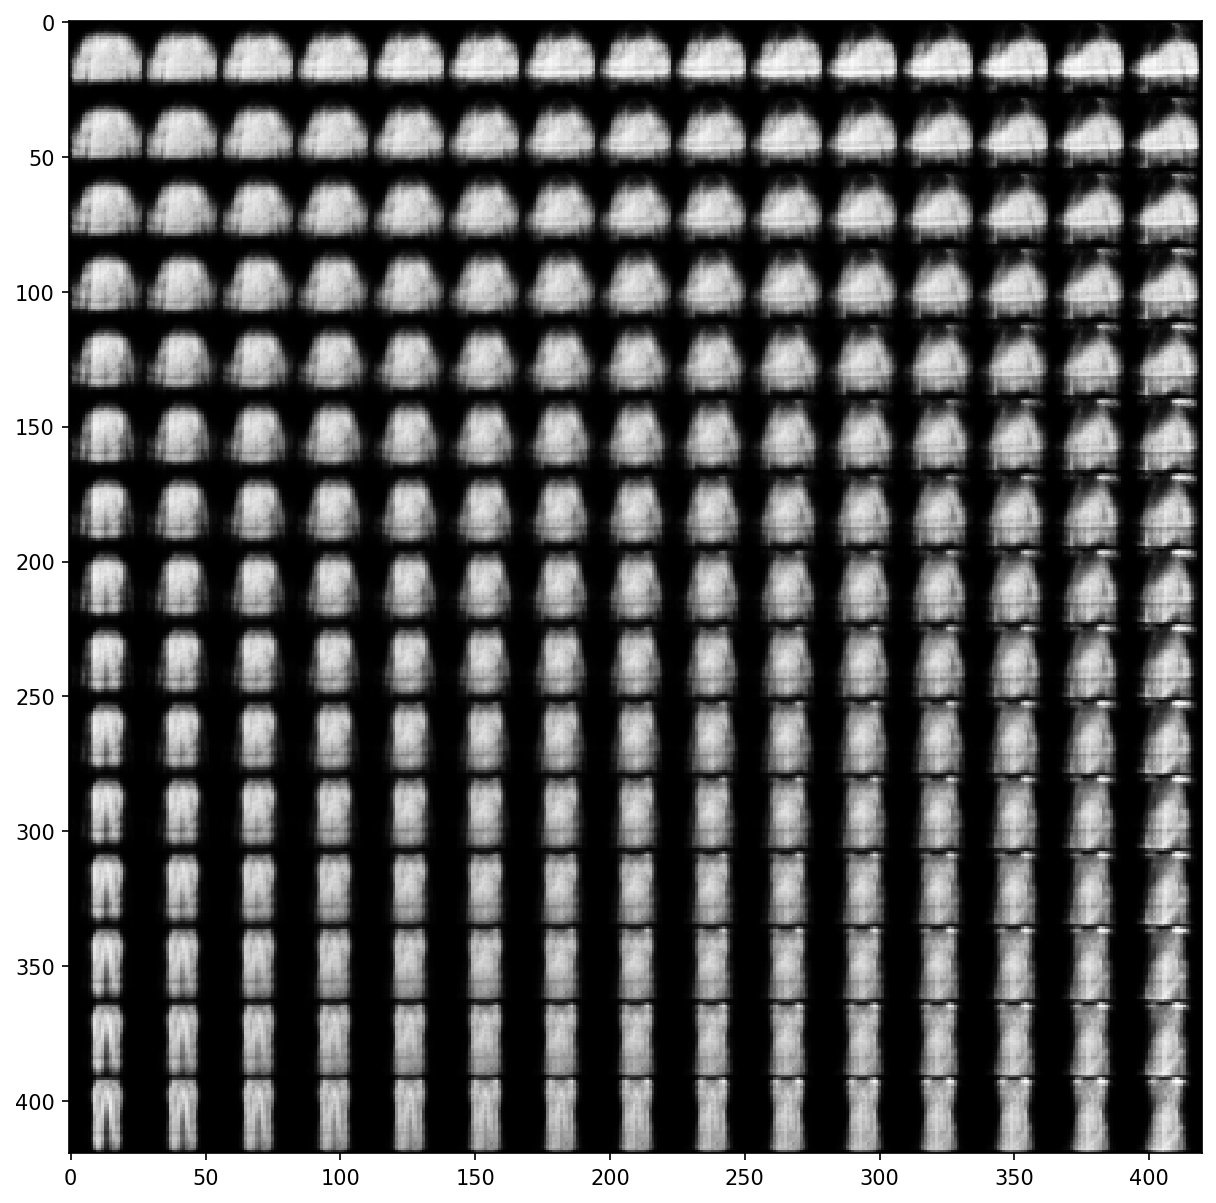

In [231]:
# code modified from Hamidreza Saghir at https://github.com/hsaghir/VAE_intuitions
from scipy.stats import norm
n=15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))

grid_x=norm.ppf(np.linspace(0.05,0.95,n))
grid_y=norm.ppf(np.linspace(0.05,0.95,n))

for i, yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample=np.array([[xi,yi,0,0,0,0,0,0,0,0]])
        x_decoded=variational_decoder_beta(z_sample)
        digit=np.reshape(x_decoded,[28,28])
        figure[i*digit_size:(i+1)*digit_size, 
              j*digit_size:(j+1)*digit_size]=digit
        
plt.figure(figsize=(10,10), dpi=150)
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [233]:
grid_x

array([-1.64485363e+00, -1.20404696e+00, -9.20822976e-01, -6.97141435e-01,
       -5.03965367e-01, -3.28072108e-01, -1.61844167e-01, -1.39145821e-16,
        1.61844167e-01,  3.28072108e-01,  5.03965367e-01,  6.97141435e-01,
        9.20822976e-01,  1.20404696e+00,  1.64485363e+00])

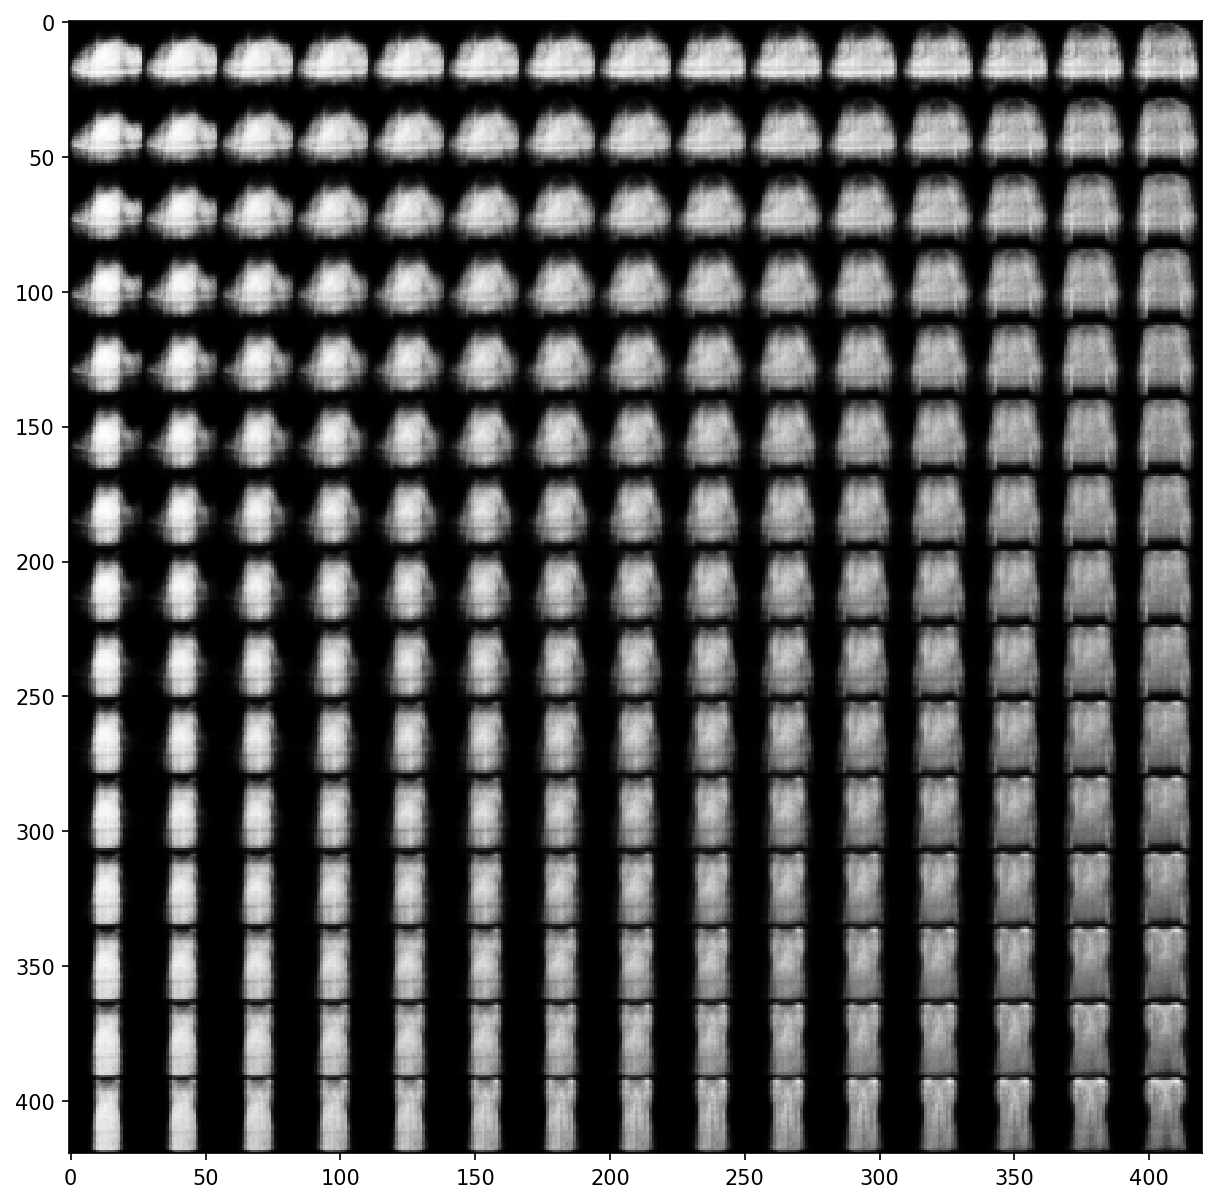

In [232]:
# code modified from Hamidreza Saghir at https://github.com/hsaghir/VAE_intuitions
from scipy.stats import norm
n=15
digit_size = 28
figure = np.zeros((digit_size*n, digit_size*n))

grid_x=norm.ppf(np.linspace(0.05,0.95,n))
grid_y=norm.ppf(np.linspace(0.05,0.95,n))

for i, yi in enumerate(grid_x):
    for j,xi in enumerate(grid_y):
        z_sample=np.array([[0,yi,0,xi,0,0,0,0,0,0]])
        x_decoded=variational_decoder_beta(z_sample)
        digit=np.reshape(x_decoded,[28,28])
        figure[i*digit_size:(i+1)*digit_size, 
              j*digit_size:(j+1)*digit_size]=digit
        
plt.figure(figsize=(10,10), dpi=150)
plt.imshow(figure, cmap='Greys_r')
plt.show()

In [ ]:
# plot the results
def plot_single_reconstruction(model, coding): 
    reconstructions = model.predict(coding)
    
    # get the length of index_list to set number of
    # images to plot
    # Plot a random sample
    fig, axes = plt.subplots(1, 1,figsize=(1.5,3),dpi=150)
    # fig.suptitle('Digits for Sample %i' %num, size=15, x=0.2)

    axes[0].imshow(np.reshape(X_valid[index_list[i],:,:],[28,28]), cmap='Greys_r')
    axes[0][i].axis('off')
    axes[0][i].set_title(str(index_list[i]))
    axes[1][i].imshow(np.reshape(reconstructions[index_list[i],:,:],[28,28]), cmap='Greys_r')
    axes[1][i].axis('off')
        
    plt.show()